# 2階層でのPredictie Codingの確認

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from dataset import Dataset

I_scale = 1.0
dataset = Dataset(scale=I_scale)

In [5]:
#k1 = 0.5
#k2 = 1.0

k1 = 0.0005 # rの学習率
k2 = 0.005 # Uの学習率
iteration = 30

sigma_sq    = 1.0 # Iの生成観測分布の分散
sigma_sq_td = 10.0 # rの生成観測分布の分散
alpha1      = 1.0 # rの事前分布の精度パラメータ (分散の逆数)
alpha2      = 0.05 # r_tdの事前分布の精度パラメータ (分散=20.0, 標準偏差4.5)
lambd       = 0.02 # Uの事前分布の精度パラメータ　(分散=50.0, 標準偏差7.1)

U_scale     = 7.0

Us  = (np.random.rand(3,256,32)-0.5) * U_scale
Uh  = (np.random.rand(96,128)  -0.5) * U_scale
rs  = np.zeros([96],  dtype=np.float32)
rh  = np.zeros([128], dtype=np.float32)

patch_size = len(dataset.patches) # 2375

for k in range(patch_size):
    rs = np.zeros([96], dtype=np.float32)
    rh = np.zeros([128], dtype=np.float32)    
    error_tds = np.zeros([96], dtype=np.float32)
    
    for i in range(iteration):
        r_tds = Uh.dot(rh)
        
        for j in range(3):
            I = dataset.get_image(k, j)
            r    = rs[32*j:32*(j+1)]
            r_td = r_tds[32*j:32*(j+1)]
            U = Us[j]
            Ur = U.dot(r)
            error    = I - Ur
            error_td = r_td - r
            dr = (k1 / sigma_sq) * U.T.dot(error) + (k1/sigma_sq_td) * error_td - k1 * alpha1 * r
            dU = (k2 / sigma_sq) * np.outer(error, r) - k2 * lambd * U
            rs[32*j:32*(j+1)] += dr
            Us[j] += dU            
            error_tds[32*j:32*(j+1)] = error_td
            
        drh = (k1 / sigma_sq_td) * Uh.T.dot(error_tds)     - k1 * alpha2 * rh
        dUh = (k2 / sigma_sq_td) * np.outer(error_tds, rh) - k2 * lambd * Uh        

        rh += drh
        Uh += dUh

    if k % 100 == 0:
        print("us mean={} std={}".format(np.mean(Us[0]), np.std(Us[0])))                                    
        print("rs mean={} std={}".format(np.mean(rs), np.std(rs)))
    
    if k % 40 == 0:
        k2 = k2 / 1.015

us mean=-0.002621377464355949 std=2.033405525454091
rs mean=-9.841083552829128e-19 std=4.311007272275264e-17
us mean=-0.0020392119817024146 std=1.5183405545106288
rs mean=-4.79891496070195e-05 std=0.0015332348411902785
us mean=-0.0017200827036341002 std=1.1454782971966935
rs mean=-0.0009704793919809163 std=0.01372196152806282
us mean=-0.0015251452127804472 std=0.8735855442866959
rs mean=0.003998798783868551 std=0.01630520261824131
us mean=-0.0014750485460847482 std=0.672704397021351
rs mean=-3.60335301746523e-18 std=1.0751384567287404e-16
us mean=-0.0013373909703652872 std=0.5233963002178417
rs mean=0.0004384914645925164 std=0.007796991150826216
us mean=-0.006257445111612781 std=0.4401087402015435
rs mean=0.008647619746625423 std=0.19376669824123383
us mean=-0.018606494200642715 std=0.45809417360010085
rs mean=0.01622944511473179 std=0.1522696167230606
us mean=-0.01761705756817898 std=0.4646375101423605
rs mean=0.004226560238748789 std=0.09953221678733826
us mean=-0.01386864048846888 s

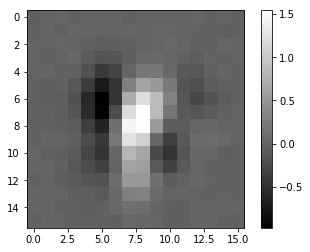

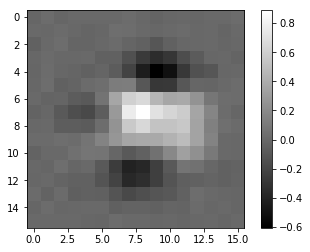

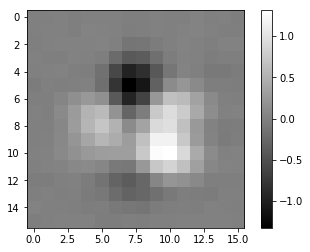

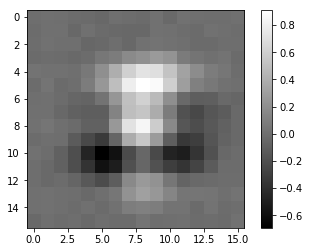

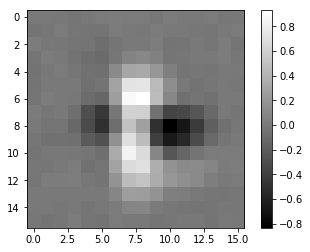

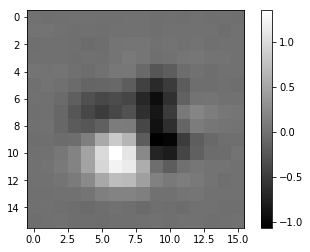

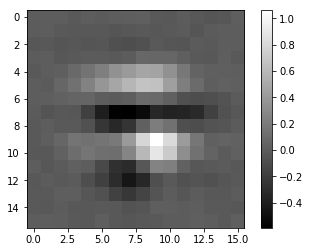

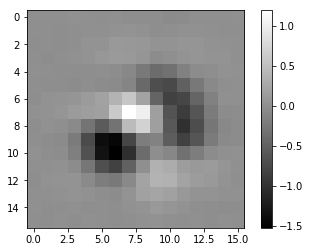

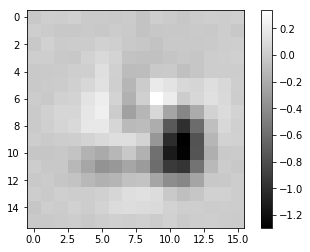

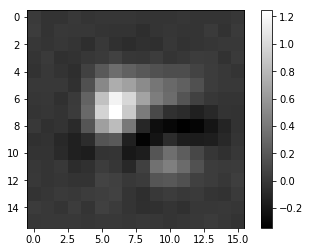

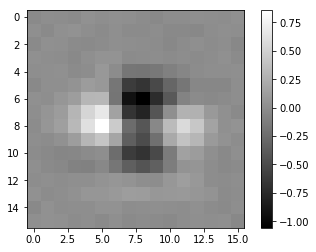

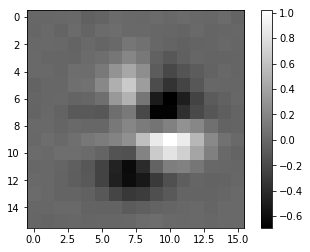

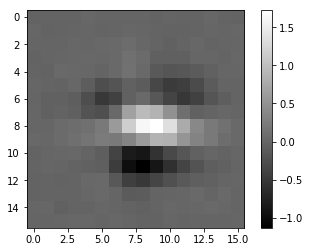

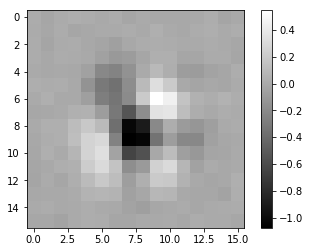

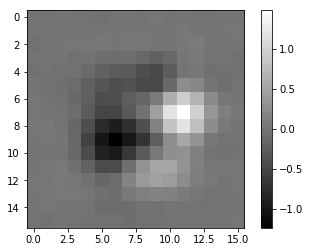

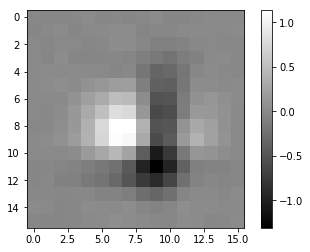

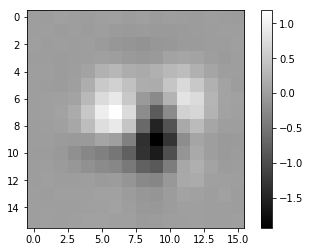

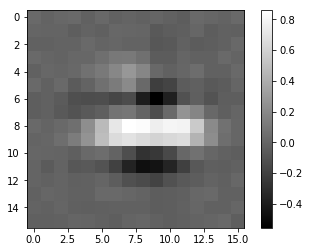

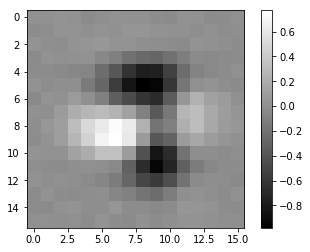

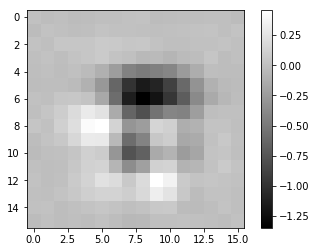

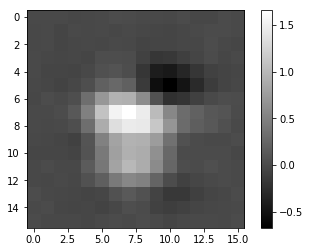

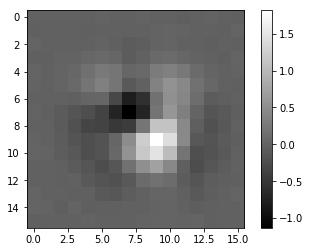

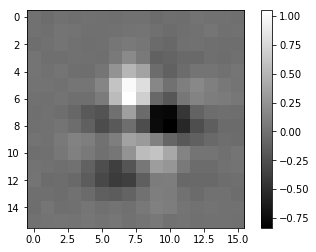

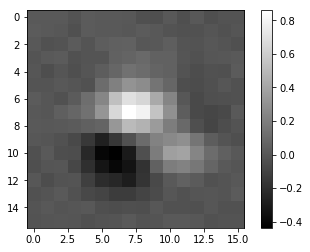

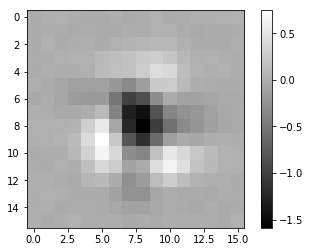

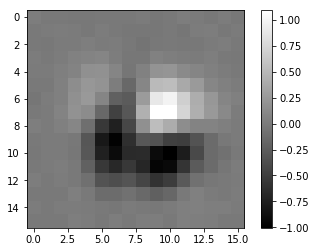

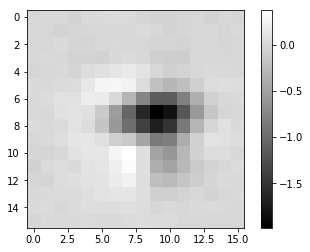

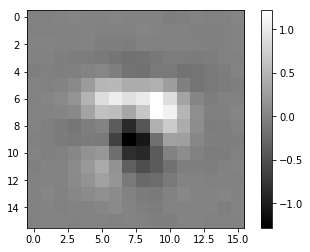

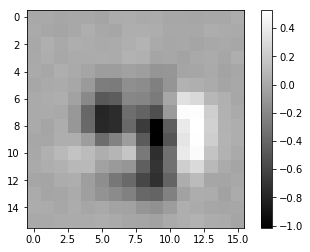

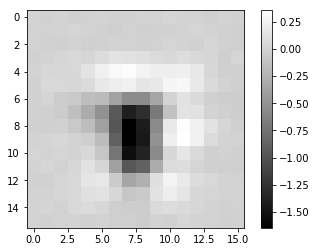

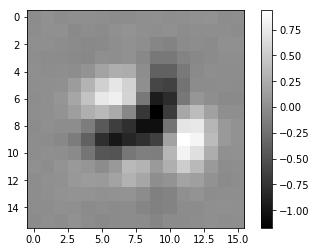

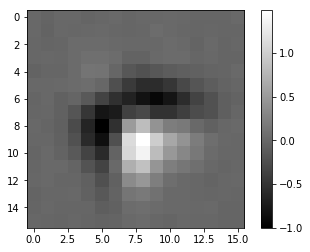

In [6]:
for i in range(32):
    u = Us[1][:,i].reshape(16,16)
    plt.figure()
    plt.imshow(u, cmap='gray')
    plt.colorbar()
    plt.show()

In [10]:
print(Uh.shape) # (96, 128)
print(np.mean(Uh))
print(np.std(Uh))

#print(Uh[0]) # ()

(96, 128)
9.016431784802715e-05
0.01837809547794743


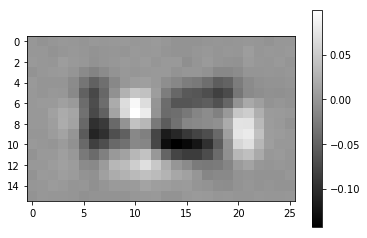

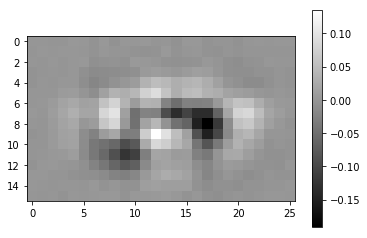

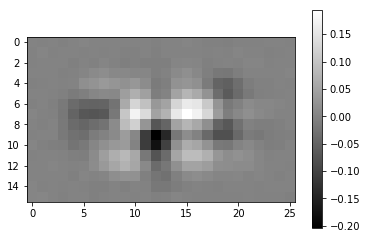

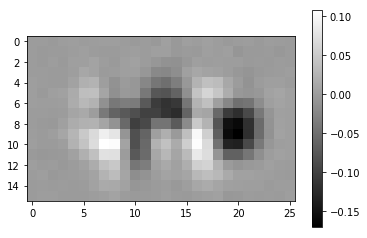

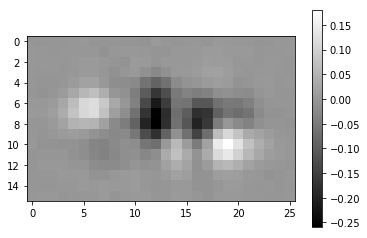

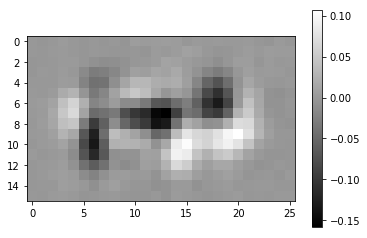

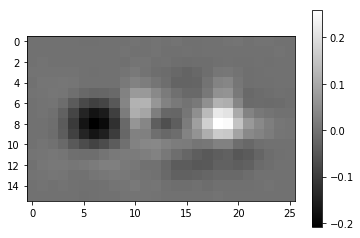

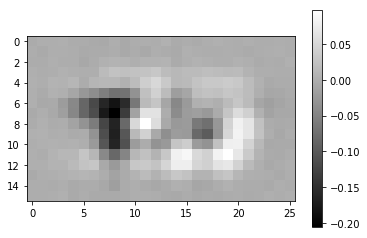

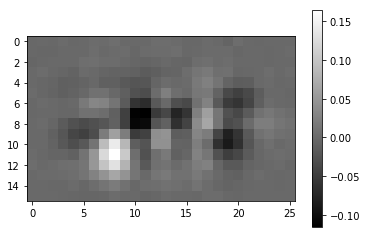

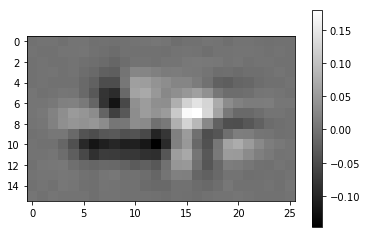

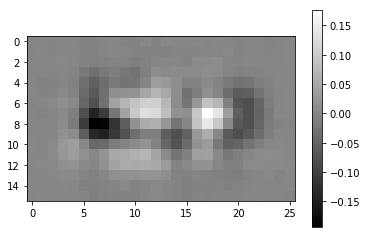

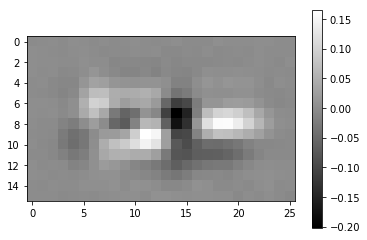

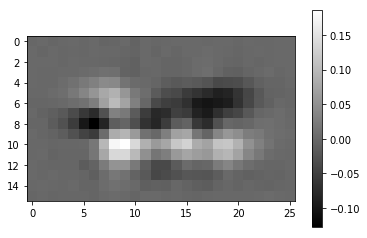

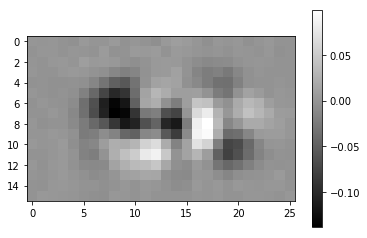

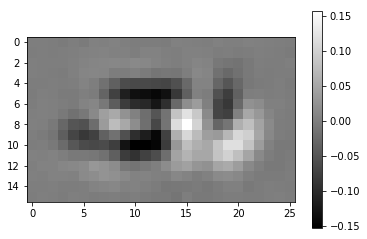

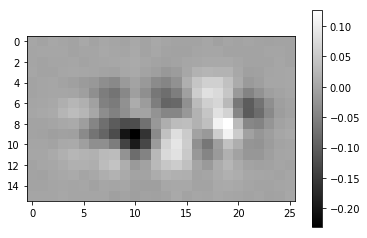

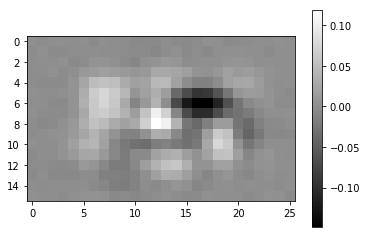

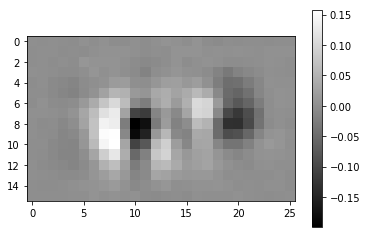

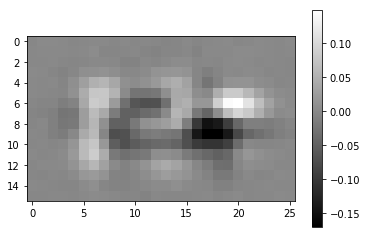

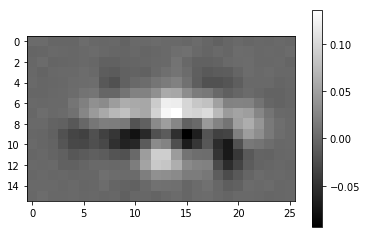

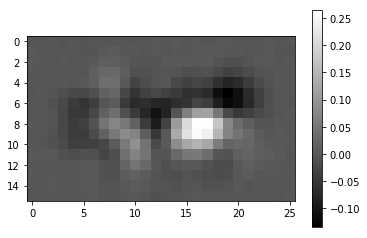

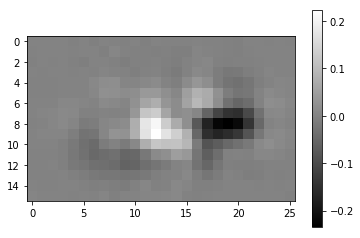

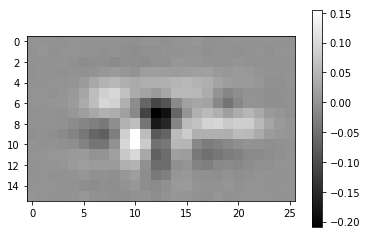

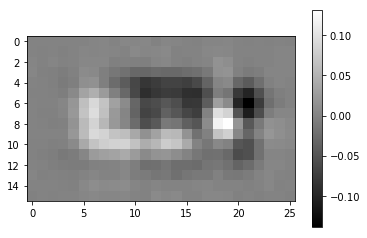

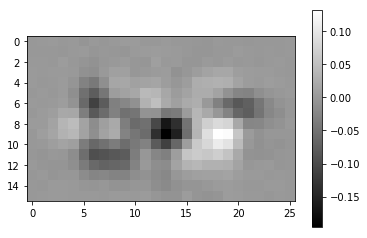

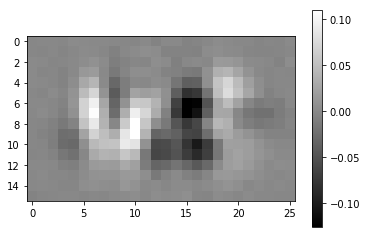

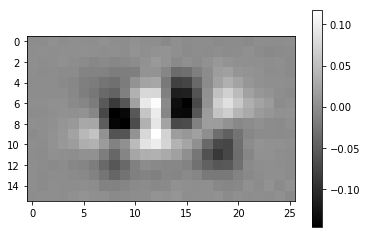

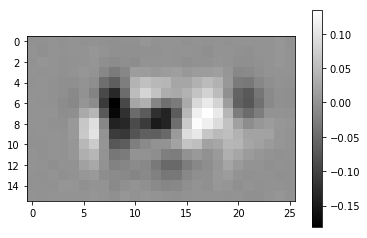

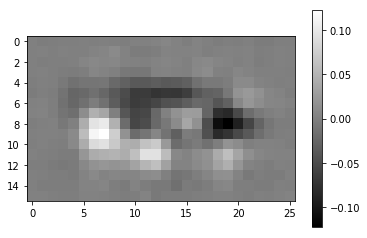

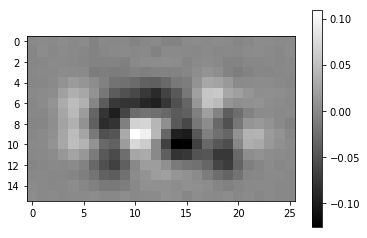

In [40]:
def get_level2_rf(index):
    Uh0 = Uh[:,index][0:32]
    Uh1 = Uh[:,index][32:64]
    Uh2 = Uh[:,index][64:96]

    UU0 = Us[0].dot(Uh0).reshape((16,16))
    UU1 = Us[1].dot(Uh1).reshape((16,16))
    UU2 = Us[2].dot(Uh2).reshape((16,16))

    RF = np.zeros((16,26), dtype=np.float32)
    RF[:, 5*0:5*0+16] += UU0
    RF[:, 5*1:5*1+16] += UU1
    RF[:, 5*2:5*2+16] += UU2    
    return RF

for i in range(30):
    rf = get_level2_rf(i)    
    plt.figure()
    plt.imshow(rf, cmap='gray')
    plt.colorbar()
    plt.show()

In [29]:
import imageio

In [41]:
for i in range(32):
    u1 = Us[1][:,i].reshape(16,16)
    imageio.imwrite("results/u1_{:0>2}.png".format(i), u1)
    
for i in range(128):
    u2 = get_level2_rf(i)
    imageio.imwrite("results/u2_{:0>3}.png".format(i), u2)